# Lab 9: Coding with the Keras API

In this lab, we will improve the performance of the base line neural network model ([from Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/cnn)) which classifies the CIFAR 10 data. You can experiment with modifing the network model, by adding more kernel filters or neurons and more layers. We will use the regularisation techniqies that we have seen in the lessons to pervent overfitting and improve performance on the validation and test data. You may use any of techniques, just be careful not to use so much regularisation that it causes the model to underfit. Aiming for the model to be slightly overfitting is a good target.

It is recommended to approach this lab systematically:
* Make the changes to the network individually.
* Record the Train and Test Accuracy value with each change to the network to verify if their is a quantifiable improvement with each change.

## (a) Introduction to the Notebook

 In this example to reduce training time and computation, we will train our network using the simple [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
![link text](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

This notebook contains standard keras/Tensorflow code to perform data processing, training set up and testing metrics, as outlined in the steps below. This will allow you to trial improvemnts to the network.

1. Load Dataset - We will import the CIFAR-10 Dataset using the Tensorflow Data Set API.
2. Prepare Data - We will slightly modify the dataset before it is sent to the model for training.
3. Model Coding We will write code to build the model using the Tensorflow keras API.
   * You will code your neural network model in this section
4. Compile Model - We will complile the model and verify that it has been correctly constructed.
5. Train Model - We will train the model using the imported dataset.
6. Test Model - We test the model on the training data and obtain a classification report and confusion matrix.

The principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials. Tutorials on [image classification](https://www.tensorflow.org/tutorials/images/classification) and [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) are useful for this Example.  

Note in your final notebook that you upload please only include one network architecture!

#House Keeping

In [ ]:
from __future__ import print_function

%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,MaxPooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, RandomFlip, RandomZoom


import numpy as np

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU.

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

#1. Load Dataset

In this assignment, we will be using the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.htmlhttps://). CIFAR-10 is often used as a "Hello World" dataset that is often used to ensure a network architecture is working before moving on to training with more complex datasets.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (airplane, automobile, **bird**, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. There are 50,000 training images and 10,000 test images.

We will use the [Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) API to download the CIFAR10 dataset.

In [ ]:
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =32       # Image Height (fixed)
W_trg =32       # image Width (fixed)

# Labels corresponding to categories
label_str = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# We initally load the raw training/validation/test dataset
import tensorflow_datasets as tfds
ds,info= tfds.load("cifar10",with_info=True)

raw_train = tfds.load('cifar10', split='train[0%:90%]')
raw_val = tfds.load('cifar10', split='train[91%:100%]')
raw_test = tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.JQVU5L_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.JQVU5L_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# 2. Prepare Data

After importing raw datasets using tfds load, we create an input pipeline that processes & batches this data before it is supplied to the model for training using the virtual machine GPU.

In [ ]:

def data_pipe(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image-0.5
  label = tf.cast(label, tf.float32)
  return image,label


In [ ]:
def gen_tr_datasets(src_dataset):
    # Define Datasets
    #src_dataset = src_dataset.shuffle(num_train_examples)
    tr_dataset = src_dataset.map(lambda x: (x['image'],x['label']))
    tr_dataset = tr_dataset.map(data_pipe)
    tr_dataset = tr_dataset.batch(batch_size)
    return tr_dataset

def gen_val_datasets(src_dataset):
    # Define Datasets
    test_dataset = src_dataset.map(lambda x: (x['image'],x['label']))
    test_dataset = test_dataset.map(data_pipe)
    test_dataset = test_dataset.batch(batch_size)
    return test_dataset

# Generate the datasets
train_dataset = gen_tr_datasets(raw_train)
val_dataset = gen_val_datasets(raw_val)
test_dataset = gen_val_datasets(raw_test)

Plot some examples of the training dataset.

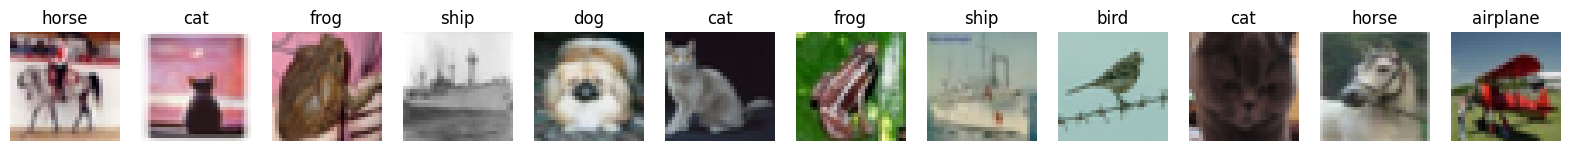

In [ ]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image, label in train_dataset.take(n_plots):  # Only take a single example
  axarr[i].imshow(image[0,:,:,:]+0.5)
  axarr[i].axis('off')
  axarr[i].title.set_text(label_str[int(label[0])])
  i = i+1



# 3. Model Coding

In this section You may develop your own model architecture to perform image recognition with the CIFAR-10 Dataset.

Within Keras there are two API's for coding network models:  [Sequential](https://https://www.tensorflow.org/guide/keras/sequential_model) and [Functional](https://www.tensorflow.org/guide/keras/functional) (which is more general and enables us to include feedforward paths which are required to code more advanced networks). For this lab we will use the Functional model. A skeleton model is given in the code cell below.

 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
 * MaxPooling and Average Pooling are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) and [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)
 * Dense Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation)

Regularisation Methods:
* [L1 & L2 Regularisation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)
* [Dropout Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
* Data Augmentation Layers, E.g. [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomCrop)
* [Batch Normalisation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) (Although we don't discuss batch normalisation until the next section of the course, this is proven to be one of the best regularisers and ways to improve the training performance of deep learning models)




In [ ]:
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    # Define input of model
    inputs = Input(shape=input_shape)


   ######## Add more layers to build your Architecture here ##################
    # Data Augmentation Layers
    x = RandomFlip("horizontal")(inputs)
    x = RandomZoom(0.1)(x)

    # First Convolutional Block
    x = Conv2D(32, (3, 3), padding="same", activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)  # Dropout layer for regularization

    # Second Convolutional Block
    x = Conv2D(64, (3, 3), padding="same", activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Third Convolutional Block
    x = Conv2D(128, (3, 3), padding="same", activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Flatten the feature maps into a 1D vector for the Dense layers
    x = Flatten()(x)

    # Fully Connected (Dense) Layer
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output Layer with softmax for classification
    outputs = Dense(num_classes, activation='softmax')(x)




    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We define  loss function, the optimizer and metrics.

Note the use here of [Sparse Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). This loss function allows us to input integer values for true classes. With the regular categorical cross entropy loss function the supplied labels must be frist converted to a one-hot representation,  but this special loss function allows us to avoid manually converting to the one-hot representation.


In [ ]:

# Compile Model
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# Obtain summary containing number of paramters
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

# 5. Model Training

We will now train the complied model on the cifar10 dataset using the tensorflow keras `model.fit` method.

Note that the number of epochs is set to a high number, you may not require this many epochs to train your network. [Early Stopping](https://keras.io/api/callbacks/early_stopping/) has been included to stop training once validation loss stops improving. You may wish to adjust the paramters (such as start_from_epoch) to suit your particular architecture.



In [ ]:
# Set max training epochs
epochs =55
# Enable callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,start_from_epoch=10)
# Train Model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,callbacks=[callback])

Epoch 1/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.3524 - loss: 2.4274 - val_accuracy: 0.5282 - val_loss: 1.7001
Epoch 2/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.5340 - loss: 1.6609 - val_accuracy: 0.6518 - val_loss: 1.3209
Epoch 3/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5899 - loss: 1.5059 - val_accuracy: 0.6584 - val_loss: 1.2952
Epoch 4/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.6145 - loss: 1.4581 - val_accuracy: 0.6836 - val_loss: 1.2662
Epoch 5/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6323 - loss: 1.4219 - val_accuracy: 0.7040 - val_loss: 1.2133
Epoch 6/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.6415 - loss: 1.4202 - val_accuracy: 0.7144 - val_loss: 1.1950
Epoch 7/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6536 - loss: 1.3970 - val_accuracy: 0.6978 - val_loss: 1.2273
Epoch 8/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.6527 -

We will plot the loss and accuracy for the training and validation data sets.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


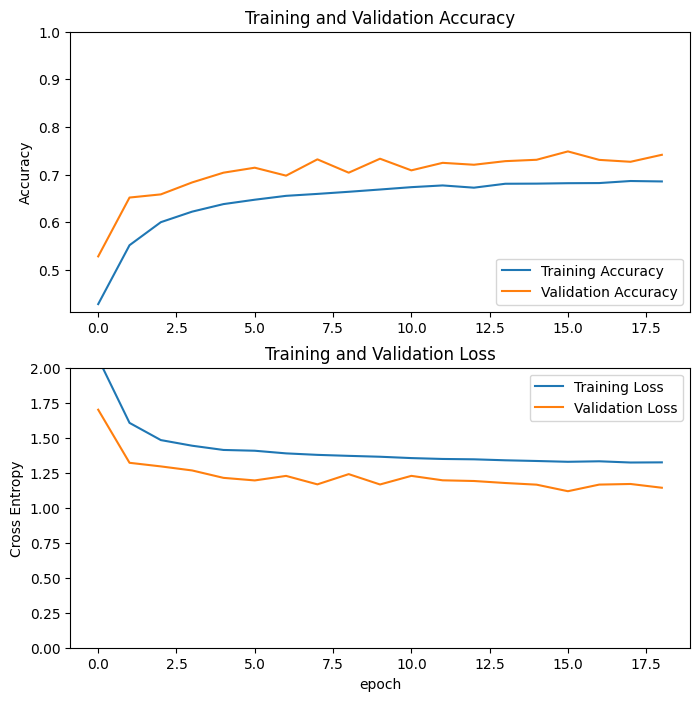

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 6. Model Testing
We will iterate through the test data and analyse the results using tools from sklearn. We create a classification report, a confusion matrix and also plot a few examples from the test set.

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))


Create and plot a confusion matrix.

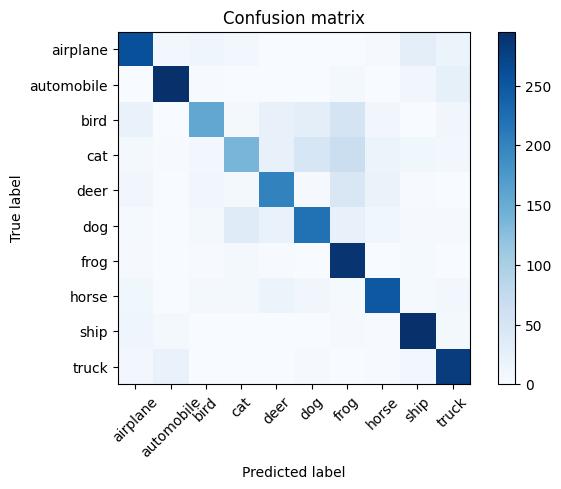

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

Generate & print the classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.78      0.77      0.77       337
  automobile       0.88      0.87      0.88       338
        bird       0.76      0.51      0.61       306
         cat       0.67      0.43      0.52       323
        deer       0.71      0.68      0.69       297
         dog       0.70      0.68      0.69       325
        frog       0.60      0.94      0.73       307
       horse       0.80      0.79      0.79       317
        ship       0.80      0.90      0.85       326
       truck       0.78      0.87      0.82       324

    accuracy                           0.74      3200
   macro avg       0.75      0.74      0.74      3200
weighted avg       0.75      0.74      0.74      3200



Plot some test images and predicted labels.

(32, 10)
(32,)
Predictions:
 [5 8 6 9 7 1 7 8 5 4 7 2 7 9 2 7 0 8 7 1 4 6 9 5 0 8 2 8 1 8 6 0]


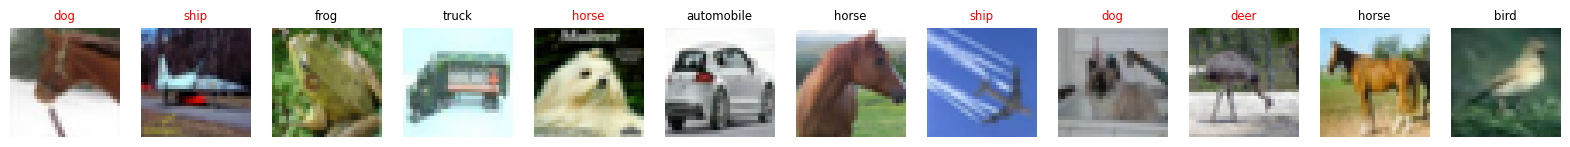

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')

  color = ('black' if predictions[i] == int(label_batch[i]) else 'red')
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1